In [1]:
#@title Runtime
use_tpu = False #@param

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve('https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf', 'IBMPlexMono-Regular.ttf')
fe = font_manager.FontEntry(
    fname='IBMPlexMono-Regular.ttf',
    name='plexmono')
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update({'axes.facecolor':'#f5f4e9', 
            'grid.color' : '#AAAAAA', 
            'axes.edgecolor':'#333333', 
            'figure.facecolor':'#FFFFFF', 
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': fe.name,
            'figure.figsize': (3.5,3.5 / 1.2),
            'ytick.left': True,
            'xtick.bottom': True   
           })

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import tensorflow as tf
import urllib
from dataclasses import dataclass
# import tensorflowjs as tfjs
# import tensorflow_decision_forests as tfdf
import json
from tqdm import tqdm
import seaborn as sns
np.random.seed(0)

In [3]:
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/hemo-positive.npz",
    "positive.npz",
)
urllib.request.urlretrieve(
    "https://github.com/ur-whitelab/peptide-dashboard/raw/master/ml/data/hemo-negative.npz",
    "negative.npz",
)
with np.load("positive.npz") as r:
    pos_data = r[list(r.keys())[0]]
with np.load("negative.npz") as r:
    neg_data = r[list(r.keys())[0]]

# create labels and stich it all into one
# tensor
# labels = np.concatenate(
#     (
#         np.ones((pos_data.shape[0], 1), dtype=pos_data.dtype),
#         np.zeros((neg_data.shape[0], 1), dtype=pos_data.dtype),
#     ),
#     axis=0,
# )
# weights = np.concatenate(
#     (np.ones((pos_data.shape[0]), dtype=pos_data.dtype), 
#      weights)
# )
# features = np.concatenate((pos_data, neg_data), axis=0)
# pos_data_lengths = np.count_nonzero(pos_data, axis=1)
# neg_data_lengths = np.count_nonzero(neg_data, axis=1)

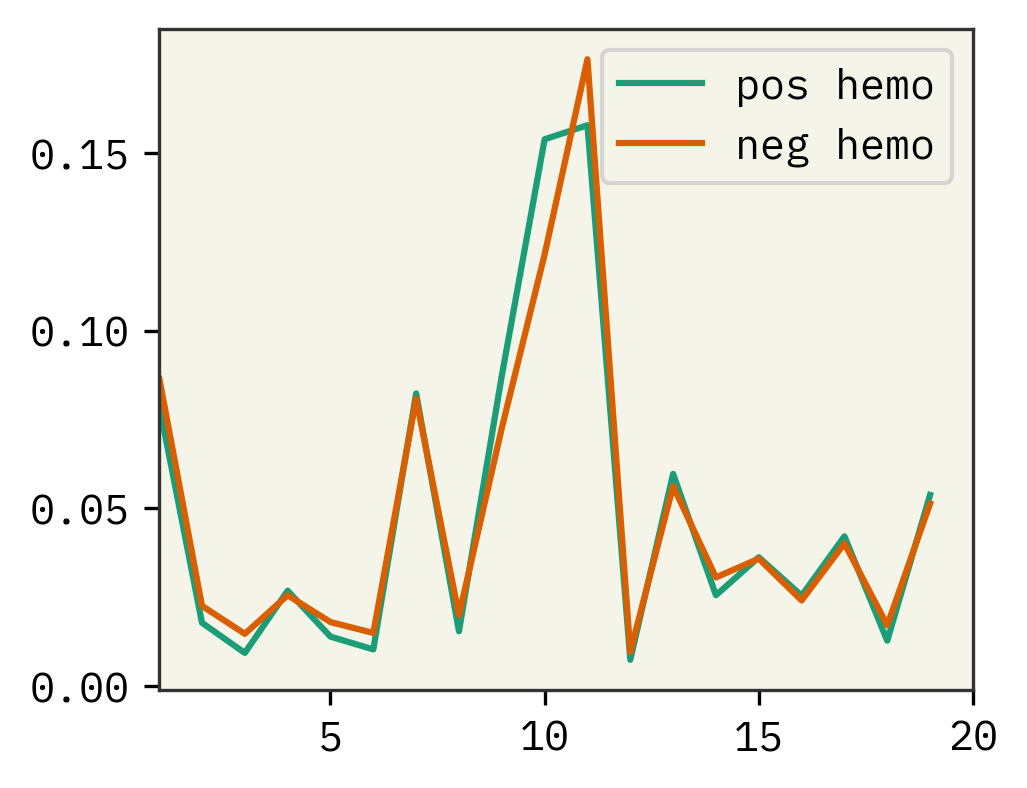

In [4]:
hist, bins = np.histogram(pos_data, bins=21)
counts_aa = hist[1:]
p_positive = counts_aa/np.sum(counts_aa)
hist, bins = np.histogram(neg_data, bins=21)
counts_aa = hist[1:]
p_negative = counts_aa/np.sum(counts_aa)
# with open("../pdb_dist.txt", 'r') as f:
#     # the probabilities in this file are sorted based on the alphabet list above
#     pdb_dist = f.read().split()
#     pdb_dist = [float(item) for item in pdb_dist]
plt.figure(dpi=300)
plt.plot(p_positive, label='pos hemo')
plt.plot(p_negative, label='neg hemo')
# plt.plot(pdb_dist, label='pdb dist')
plt.xlim([1,20])
plt.legend()

In [5]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   print(
#       '\n\nThis error most likely means that this notebook is not '
#       'configured to use a GPU.  Change this in Notebook Settings via the '
#       'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
#   raise SystemError('GPU device not found')

In [6]:
def build_fakes(n, data):
    result = []
    for _ in range(n):
        # sample this many subsequences
        k = np.clip(np.random.poisson(1), 0, len(data) - 2) + 2
        idx = np.random.choice(range(len(data)), replace=False, size=k)                        
        seq = []
        lengths = []
        # cut-up k into one new sequence
        for i in range(k):
            if np.argmin(data[idx[i]]) > 1:
                lengths.append(np.ceil(2 * np.random.randint(1, np.argmin(data[idx[i]])) / k).astype(int))
                j = np.random.randint(0, np.argmin(data[idx[i]]) - lengths[i])
            else:
                lengths.append(1)
                j = 0
            seq.append(data[idx[i]][j:j+lengths[i]])
        # pad out    
        seq.append([0] * (len(data[0]) - sum(lengths)))
        # print(seq)
        result.append(np.concatenate(seq))
        # print(result)
        # break
    return np.array(result)
sampled_vecs = build_fakes(9130*5, pos_data)

In [7]:
sampled_vecs.shape

(45650, 190)

In [8]:
X_positive = pos_data
X_negative = neg_data
X_unlabeled = sampled_vecs
print('Positive data:', pos_data.shape[0])
print('Negative data:', neg_data.shape[0])
print('Sampled unlabeled data:', len(sampled_vecs))

Positive data: 1826
Negative data: 7490
Sampled unlabeled data: 45650


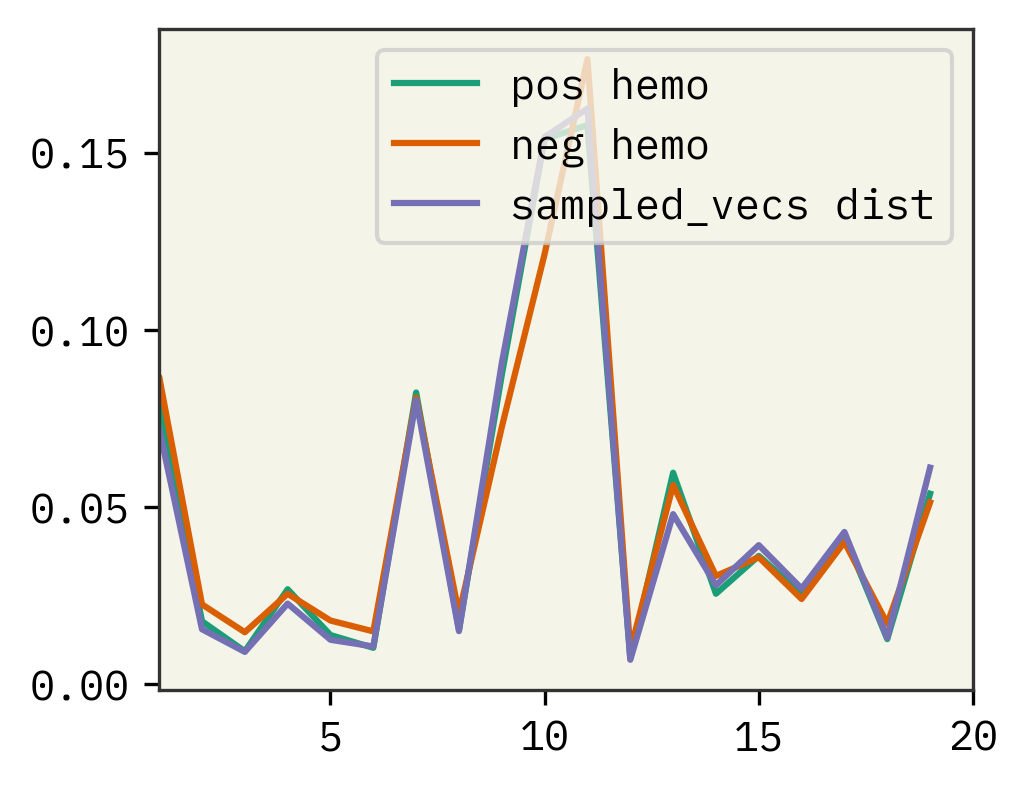

In [9]:
hist, bins = np.histogram(pos_data, bins=21)
counts_aa = hist[1:]
p_positive = counts_aa/np.sum(counts_aa)

hist, bins = np.histogram(neg_data, bins=21)
counts_aa = hist[1:]
p_negative = counts_aa/np.sum(counts_aa)

hist, bins = np.histogram(sampled_vecs, bins=21)
counts_aa = hist[1:]
p_unlabeled = counts_aa/np.sum(counts_aa)
plt.figure(dpi=300)
plt.plot(p_positive, label='pos hemo')
plt.plot(p_negative, label='neg hemo')
plt.plot(p_unlabeled, label='sampled_vecs dist')
plt.xlim([1,20])
plt.legend()

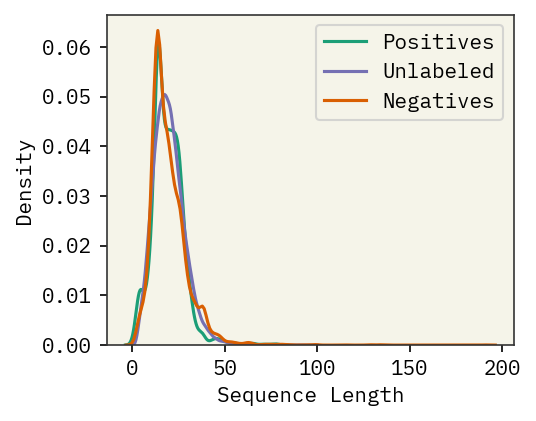

In [10]:
pos_data_lengths = np.count_nonzero(pos_data, axis=1) + 1
neg_data_lengths = np.count_nonzero(neg_data, axis=1) + 1
unlabeled_data_lengths = np.count_nonzero(sampled_vecs, axis=1) + 1
fig, ax = plt.subplots(dpi=150)
sns.kdeplot(pos_data_lengths, ax=ax, label='Positives', color='C0')
ax.set_xlabel('Sequence Length')
# ax.set_title(f'{peptide_label}')
sns.kdeplot(unlabeled_data_lengths, ax=ax, label='Unlabeled', color='C2')
sns.kdeplot(neg_data_lengths, ax=ax, label='Negatives', color='C1')
plt.legend()
# plt.savefig(f'length_dist_hemolytic.png', dpi=600, transparent=False, bbox_inches='tight')

In [11]:
# Shuffling data
np.random.seed(0)
shuffled_indices = np.random.permutation(len(pos_data))
X_positive = pos_data[shuffled_indices]
shuffled_indices = np.random.permutation(len(neg_data))
X_negative = neg_data[shuffled_indices]
shuffled_indices = np.random.permutation(len(sampled_vecs))
X_unlabeled = sampled_vecs[shuffled_indices]

In [12]:
# def decoder(seq_vector):
#   alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
#   seq = []
#   for i, index in enumerate(seq_vector):
#     if index == 0:
#       break
#     seq.append(alphabet[int(index)-1])
#   seq = ''.join(seq)
#   return seq
# # need to decode postive and negative data to get UniRep representations
# pos_sequences = []
# for f in pos_data:
#   pos_sequences.append(decoder(f))

# neg_sequences = []
# for f in neg_data:
#   neg_sequences.append(decoder(f))

# sampled_sequences = []
# for i, f in enumerate(sampled_vecs):
#     sampled_sequences.append(decoder(f))

In [13]:
# def mahalanobis_distance(x, data):
#     data = np.unique(data, axis=0)
#     x_minus_mu = x - np.mean(data, axis=0, keepdims=True)
#     cov = np.cov(data.T)
#     inv_covmat = np.linalg.pinv(cov)
#     left_term = x_minus_mu @ inv_covmat
#     mahal = left_term @ x_minus_mu.T
#     return mahal.diagonal()
# from jax_unirep import get_reps
# h_avg, h_final, c_final = get_reps(pos_sequences)
# pos_UniRep = h_avg

# h_avg, h_final, c_final = get_reps(sampled_sequences)
# unlabeled_UniRep = h_avg

# unlabeled_mahal_d = mahalanobis_distance(unlabeled_UniRep, pos_UniRep)
# sorted_max_mahal_d_index = np.argsort(unlabeled_mahal_d)[::-1]
# outlier_index = sorted_max_mahal_d_index[sorted_max_mahal_d_index[:400]]
# initial_RNs = X_unlabeled[outlier_index]

In [12]:
from sklearn.model_selection import train_test_split
X_train_positive, X_test_positive, y_train_positive, y_test_positive = train_test_split(X_positive, np.ones(X_positive.shape[0]),
                                                                                        test_size=0.1, random_state=42)
X_train_unlabeled, X_test_unlabeled, y_train_unlabeled, y_test_unlabeled = train_test_split(X_unlabeled, np.zeros(X_unlabeled.shape[0]),
                                                                                        test_size=0.5, random_state=42)

In [15]:
X_train_positive.shape

(1643, 190)

In [16]:
P.shape

(1293, 190)

In [15]:
np.random.seed(42)
spie_rate = 0.2
spie_tolerance=0.05
X_train = np.vstack([X_train_positive, X_unlabeled])
y_train = np.concatenate([np.ones(X_train_positive.shape[0]), np.zeros(X_unlabeled.shape[0])])
# Step 1. Infuse spies
spie_mask = np.random.random(X_train_positive.shape[0]) < spie_rate
# Unknown mix + spies
MS = np.vstack([X_train[y_train == 0], X_train[y_train == 1][spie_mask]])
MS_spies = np.hstack([np.zeros((y_train == 0).sum()), np.ones(spie_mask.sum())])
# Positive with spies removed
P = X_train[y_train == 1][~spie_mask]
# Combo
MSP = np.vstack([MS, P])
# Labels
MSP_y = np.hstack([np.zeros(MS.shape[0]), np.ones(P.shape[0])])
shuffler = np.random.permutation(len(MSP))
MSP = MSP[shuffler]
MSP_y = MSP_y[shuffler]

In [20]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(vocab_size=21, # include gap
                example_number=len(X_positive), 
                batch_size=16, 
                buffer_size=10000,
                rnn_units=64,
                hidden_dim=64,
                embedding_dim=32,
                reg_strength=0,
                lr=1e-3,
                drop_rate=0.1
               )

def counts_aa(vec):
    counts =  tf.histogram_fixed_width(vec, [0, 20], nbins=21)[1:]
    return counts/tf.reduce_sum(counts)

def build_model(L):
    inputs = tf.keras.Input(shape=(L,))
    input_f = tf.keras.Input(shape=(20,))
    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)

    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(x)
    x = tf.keras.layers.Concatenate()([x, input_f])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=[inputs, input_f], outputs=yhat, name='hemo-rnn')
    return model
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.9,
                                                        patience=5, min_lr=1e-7)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='auc', patience=20, min_delta=1e-2, restore_best_weights=True)
L = None
decay_epochs = 50
N = len(X_train_positive)
decay_steps = N  // config.batch_size * decay_epochs
tf.keras.backend.clear_session()
model = build_model(L)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
      config.lr, decay_steps, alpha=1e-3)
opt = tf.optimizers.Adam(lr_decayed_fn)
model.compile(
        optimizer=opt,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[tf.keras.metrics.AUC(from_logits=False), tf.keras.metrics.BinaryAccuracy(threshold=0.5)],
        )
history = model.fit(
    [MSP, np.array([counts_aa(xi) for xi in MSP])] , MSP_y,
#     validation_data=([X_test, np.array([counts_aa(xi) for xi in X_test])] , y_test), 
    epochs=200,
    batch_size=1024,
#     batch_size=64,
#     steps_per_epoch=100,
    # early_stopping
    callbacks=[early_stopping],
    verbose=1,
#         class_weight=class_weights
)
#     break
# model.evaluate([X_test, np.array([counts_aa(xi) for xi in X_test])] , y_test)


Epoch 1/50
47/47 [==============================] - 18s 52ms/step - loss: 0.1443 - auc: 0.5111 - binary_accuracy: 0.9658
Epoch 2/50
47/47 [==============================] - 2s 51ms/step - loss: 0.1271 - auc: 0.5358 - binary_accuracy: 0.9727
Epoch 3/50
47/47 [==============================] - 2s 51ms/step - loss: 0.1241 - auc: 0.5780 - binary_accuracy: 0.9726
Epoch 4/50
47/47 [==============================] - 2s 52ms/step - loss: 0.1195 - auc: 0.6635 - binary_accuracy: 0.9725
Epoch 5/50
47/47 [==============================] - 2s 49ms/step - loss: 0.1126 - auc: 0.7378 - binary_accuracy: 0.9725
Epoch 6/50
47/47 [==============================] - 2s 51ms/step - loss: 0.1066 - auc: 0.7775 - binary_accuracy: 0.9728
Epoch 7/50
47/47 [==============================] - 2s 51ms/step - loss: 0.1025 - auc: 0.8063 - binary_accuracy: 0.9730
Epoch 8/50
47/47 [==============================] - 2s 51ms/step - loss: 0.1007 - auc: 0.8216 - binary_accuracy: 0.9730
Epoch 9/50
47/47 [=====================

In [21]:
# prob = self.first_model.predict_proba(MS)[:, 1]
prob_1 = model.predict([MS, np.array([counts_aa(xi) for xi in MS])])

(array([45650.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,   350.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

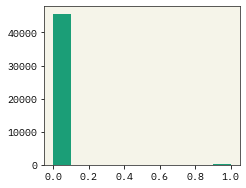

In [22]:
plt.hist(prob_1)

In [23]:
# Find optimal t
t = 0.0001
spie_tolerance=0.005
while  MS_spies[np.squeeze(prob_1 <= t)].sum()/MS_spies.sum()  <= spie_tolerance:
    t += 0.0001
print('Optimal t is {0:.06}'.format(t))
print('Positive group size {1}, captured spies {0:.02%}'.format(
    MS_spies[np.squeeze(prob_1 > t)].sum()/MS_spies.sum(), (prob_1 > t).sum()))
print('Likely negative group size {1}, captured spies {0:.02%}'.format(
    MS_spies[np.squeeze(prob_1 <= t)].sum()/MS_spies.sum(), (prob_1 <= t).sum()))

Optimal t is 0.0004
Positive group size 38189, captured spies 98.29%
Likely negative group size 7811, captured spies 1.71%


In [24]:
# likely negative group
N = MS[(MS_spies == 0) & (np.squeeze(prob_1 <= t))]
P = X_train[y_train == 1]
NP = np.vstack([N, P])
Labels = np.hstack([np.zeros(N.shape[0]), np.ones(P.shape[0])])
shuffler = np.random.permutation(len(NP))
NP = NP[shuffler]
Labels = Labels[shuffler]

(array([7805.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1643.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

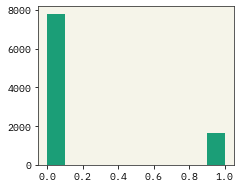

In [25]:
plt.hist(Labels)

In [26]:
len(P)

1643

In [27]:
len(X_unlabeled)

45650

In [28]:
L= None
X_test = np.concatenate([X_test_positive, X_negative])
y_test = np.concatenate([np.ones(y_test_positive.shape[0]), np.zeros(X_negative.shape[0])])
tf.keras.backend.clear_session()
model_2 = build_model(L)
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
      config.lr, decay_steps, alpha=1e-3)
opt = tf.optimizers.Adam(1e-3)
model_2.compile(
        optimizer=opt,
        loss=tf.keras.losses.BinaryFocalCrossentropy(from_logits=False),
        metrics=[tf.keras.metrics.AUC(from_logits=False), tf.keras.metrics.BinaryAccuracy(threshold=0.5)],
        )
history_2 = model_2.fit(
    [NP, np.array([counts_aa(xi) for xi in NP])] , Labels,
    validation_data=([X_test, np.array([counts_aa(xi) for xi in X_test])] , y_test), 
    epochs=200,
    batch_size=128,
#     batch_size=64,
#     steps_per_epoch=100,
    # early_stopping
    callbacks=[early_stopping],
    verbose=1,
#         class_weight=class_weights
)

Epoch 1/200
74/74 [==============================] - 23s 120ms/step - loss: 0.1347 - auc: 0.6154 - binary_accuracy: 0.8099 - val_loss: 0.1249 - val_auc: 0.5673 - val_binary_accuracy: 0.8467
Epoch 2/200
74/74 [==============================] - 3s 41ms/step - loss: 0.0902 - auc: 0.8405 - binary_accuracy: 0.8577 - val_loss: 0.1924 - val_auc: 0.6044 - val_binary_accuracy: 0.6424
Epoch 3/200
74/74 [==============================] - 3s 39ms/step - loss: 0.0743 - auc: 0.9018 - binary_accuracy: 0.8822 - val_loss: 0.2464 - val_auc: 0.6335 - val_binary_accuracy: 0.5346
Epoch 4/200
74/74 [==============================] - 3s 40ms/step - loss: 0.0642 - auc: 0.9299 - binary_accuracy: 0.9002 - val_loss: 0.2821 - val_auc: 0.6314 - val_binary_accuracy: 0.4885
Epoch 5/200
74/74 [==============================] - 3s 40ms/step - loss: 0.0573 - auc: 0.9441 - binary_accuracy: 0.9149 - val_loss: 0.2866 - val_auc: 0.6461 - val_binary_accuracy: 0.5618
Epoch 6/200
74/74 [==============================] - 3s 40

74/74 [==============================] - 3s 41ms/step - loss: 0.0067 - auc: 0.9993 - binary_accuracy: 0.9923 - val_loss: 1.3550 - val_auc: 0.6921 - val_binary_accuracy: 0.3108
Epoch 45/200
74/74 [==============================] - 3s 40ms/step - loss: 0.0087 - auc: 0.9982 - binary_accuracy: 0.9903 - val_loss: 1.2788 - val_auc: 0.6851 - val_binary_accuracy: 0.3329
Epoch 46/200
74/74 [==============================] - 3s 40ms/step - loss: 0.0050 - auc: 0.9996 - binary_accuracy: 0.9939 - val_loss: 1.3823 - val_auc: 0.6933 - val_binary_accuracy: 0.3312
Epoch 47/200
74/74 [==============================] - 3s 39ms/step - loss: 0.0034 - auc: 0.9998 - binary_accuracy: 0.9958 - val_loss: 1.4706 - val_auc: 0.7115 - val_binary_accuracy: 0.3626
Epoch 48/200
74/74 [==============================] - 3s 42ms/step - loss: 0.0046 - auc: 0.9992 - binary_accuracy: 0.9952 - val_loss: 1.4306 - val_auc: 0.7083 - val_binary_accuracy: 0.3317
Epoch 49/200
74/74 [==============================] - 3s 36ms/step -

74/74 [==============================] - 3s 38ms/step - loss: 0.0035 - auc: 0.9997 - binary_accuracy: 0.9962 - val_loss: 1.4434 - val_auc: 0.7006 - val_binary_accuracy: 0.3421
Epoch 88/200
74/74 [==============================] - 3s 39ms/step - loss: 0.0010 - auc: 1.0000 - binary_accuracy: 0.9992 - val_loss: 1.7774 - val_auc: 0.7064 - val_binary_accuracy: 0.3107
Epoch 89/200
74/74 [==============================] - 3s 40ms/step - loss: 7.4070e-04 - auc: 0.9999 - binary_accuracy: 0.9996 - val_loss: 1.9338 - val_auc: 0.7002 - val_binary_accuracy: 0.3124
Epoch 90/200
74/74 [==============================] - 3s 41ms/step - loss: 5.4737e-04 - auc: 1.0000 - binary_accuracy: 0.9994 - val_loss: 1.9731 - val_auc: 0.6953 - val_binary_accuracy: 0.3155
Epoch 91/200
74/74 [==============================] - 3s 40ms/step - loss: 0.0021 - auc: 0.9999 - binary_accuracy: 0.9978 - val_loss: 2.0090 - val_auc: 0.6886 - val_binary_accuracy: 0.2958
Epoch 92/200
74/74 [==============================] - 3s 39m

Epoch 130/200
74/74 [==============================] - 3s 40ms/step - loss: 0.0092 - auc: 0.9984 - binary_accuracy: 0.9899 - val_loss: 1.3221 - val_auc: 0.7049 - val_binary_accuracy: 0.3270
Epoch 131/200
74/74 [==============================] - 3s 41ms/step - loss: 0.0012 - auc: 1.0000 - binary_accuracy: 0.9987 - val_loss: 1.7086 - val_auc: 0.6915 - val_binary_accuracy: 0.3107
Epoch 132/200
74/74 [==============================] - 3s 40ms/step - loss: 0.0013 - auc: 0.9999 - binary_accuracy: 0.9988 - val_loss: 1.6337 - val_auc: 0.7157 - val_binary_accuracy: 0.3518
Epoch 133/200
74/74 [==============================] - 3s 41ms/step - loss: 0.0011 - auc: 1.0000 - binary_accuracy: 0.9984 - val_loss: 1.8687 - val_auc: 0.6910 - val_binary_accuracy: 0.3014
Epoch 134/200
74/74 [==============================] - 3s 41ms/step - loss: 7.4956e-04 - auc: 1.0000 - binary_accuracy: 0.9989 - val_loss: 1.7550 - val_auc: 0.6828 - val_binary_accuracy: 0.3417
Epoch 135/200
74/74 [=========================

Epoch 173/200
74/74 [==============================] - 3s 42ms/step - loss: 8.0913e-05 - auc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.2225 - val_auc: 0.6747 - val_binary_accuracy: 0.3201
Epoch 174/200
74/74 [==============================] - 3s 40ms/step - loss: 4.9372e-05 - auc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.2832 - val_auc: 0.6649 - val_binary_accuracy: 0.3196
Epoch 175/200
74/74 [==============================] - 3s 41ms/step - loss: 7.3384e-05 - auc: 1.0000 - binary_accuracy: 0.9999 - val_loss: 2.4204 - val_auc: 0.6658 - val_binary_accuracy: 0.3082
Epoch 176/200
74/74 [==============================] - 3s 40ms/step - loss: 4.1088e-05 - auc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.4346 - val_auc: 0.6733 - val_binary_accuracy: 0.3110
Epoch 177/200
74/74 [==============================] - 3s 42ms/step - loss: 2.1364e-05 - auc: 1.0000 - binary_accuracy: 1.0000 - val_loss: 2.4657 - val_auc: 0.6726 - val_binary_accuracy: 0.3098
Epoch 178/200
74/74 [=========

In [29]:
model_2.evaluate([X_test, np.array([counts_aa(xi) for xi in X_test])] , y_test)

240/240 [==============================] - 3s 11ms/step - loss: 1.3688 - auc: 0.6958 - binary_accuracy: 0.3568


[1.3687913417816162, 0.6958180665969849, 0.35683566331863403]

In [19]:
np.random.seed(0)
spy_rate = 0.2
spy_mask = np.random.random(y_train_positive.shape[0]) < spy_rate
# adding unlabeled and spies: 
X_spied_unlableled = np.vstack([X_train[y_train == 0], X_train[y_train == 1][spy_mask]])
X_spied_unlableled_sorted = X_spied_unlableled
# set s to be zero for the spies
s_spied_unlableled = np.hstack([np.zeros((s == 0).sum()), np.ones(spy_mask.sum())])
s_spied_unlableled_sorted = s_spied_unlableled
shuffler = np.random.permutation(len(X_spied_unlableled))
X_spied_unlableled = X_spied_unlableled[shuffler]
s_spied_unlableled = s_spied_unlableled[shuffler]

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1314 but corresponding boolean dimension is 1460

In [18]:

np.random.seed()
shuffled_indices = np.random.permutation(len(X_train))
y_train = y_train[shuffled_indices]
# y = y[shuffled_indices]
X_train = X_train[shuffled_indices]

positive_labeled_index = np.where((y_train==1))[0]
postive_holdout_ratio = 0.1
positive_holdout_size = int(np.ceil(len(positive_labeled_index) * (postive_holdout_ratio)))
print(f'positive_holdout_size: {positive_holdout_size}')

positive_train_index = np.random.choice(positive_labeled_index,
                                                               len(positive_labeled_index)-positive_holdout_size, replace=False)
positive_holdouts_index = list(set(positive_labeled_index) - set(positive_train_index))
X_holdouts = X_train[positive_holdouts_index]
y_holdouts = y_train[positive_holdouts_index]
# y_holdouts = s_holdouts
X_train = np.delete(X_train, positive_holdouts_index, 0) 
# print(tf.reduce_sum(X_train, axis=[1,2]))
y_train = np.delete(y_train, positive_holdouts_index, 0)

print(f'Positives (labeled) count: {len(np.where(y_train==1)[0])}')
print(f'Positives-negatives (unlabeled) count: {len(np.where(y_train==0)[0])}')
n_labeled = len(np.where(y_train==1)[0]) - positive_holdout_size
n_unlabeled = len(np.where(y_train==0)[0])

positive_holdout_size: 146
Positives (labeled) count: 1314
Positives-negatives (unlabeled) count: 45650


In [21]:
spy_mask

array([False, False, False, ..., False, False, False])

In [20]:
spy_mask.sum()

293

In [25]:
# Holdout method

shuffled_indices = np.random.permutation(len(X_train_positive))
 X_train_positive = X_train_positive[shuffled_indices]
# y = y[shuffled_indices]
X = X[shuffled_indices]
positive_labeled_index = np.where((s==1))[0]
postive_holdout_ratio = 0.1
positive_holdout_size = int(np.ceil(len(positive_labeled_index) * (postive_holdout_ratio)))
print(f'positive_holdout_size: {positive_holdout_size}')
# np.random.shuffle(positive_labeled_index)
# positive_holdouts_index = positive_labeled_index[:positive_holdout_size] 
## Leaving 50% of the postives out for testing
positive_train_index = np.random.choice(positive_labeled_index,
                                                               len(positive_labeled_index)-positive_holdout_size, replace=False)
positive_holdouts_index = list(set(positive_labeled_index) - set(positive_train_index))
X_holdouts = X[positive_holdouts_index]
s_holdouts = s[positive_holdouts_index]
y_holdouts = s_holdouts
X_train = np.delete(X_train, positive_holdouts_index, 0) 
# print(tf.reduce_sum(X_train, axis=[1,2]))
y_train = np.delete(y_train, positive_holdouts_index, 0)
# X_train_pe = gen_pe_data(X_train, encoding_d=20)
# X_holdouts_pe = gen_pe_data(X_holdouts, encoding_d=20)
print(f'Positives (labeled) count: {len(np.where(s==1)[0])}')
print(f'Positives-negatives (unlabeled) count: {len(np.where(s==0)[0])}')
n_labeled = len(np.where(s==1)[0]) - positive_holdout_size
n_unlabeled = len(np.where(s==0)[0])

IndentationError: unexpected indent (2184207218.py, line 4)

In [17]:

# noisy_students = X_test_unlabeled[:len(X_train_positive)]
X_train = np.concatenate([X_train_positive, noisy_students])
y_train = np.concatenate([np.ones(X_train_positive.shape[0]), np.zeros(noisy_students.shape[0])])

NameError: name 'noisy_students' is not defined

In [14]:
unlabeled_mahal_d[sorted_max_mahal_d_index]

array([2.79902769e+06, 2.26737099e+06, 1.90480731e+06, ...,
       1.31800021e+03, 1.27068062e+03, 6.58500823e+02])

In [25]:

# counts_X_train_with_RN = counts_X_train_with_RN[shuffler]
for i in tqdm(range(50)):
        
    shuffler = np.random.permutation(len(X_train))
    X_train = X_train[shuffler]
    y_train = y_train[shuffler]
    tf.keras.backend.clear_session()
#     model = build_model(L)
    lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
          config.lr, decay_steps, alpha=1e-3)
    opt = tf.optimizers.Adam(lr_decayed_fn)
#     model.compile(
#             optimizer=opt,
#             loss=tf.keras.losses.BinaryFocalCrossentropy(from_logits=True),
#             metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)],
#             )
    history = model.fit(
        [X_train, np.array([counts_aa(xi) for xi in X_train])] , y_train,
        validation_data=([X_test, np.array([counts_aa(xi) for xi in X_test])] , y_test), 
        epochs=50,
        batch_size=16,
    #     batch_size=64,
    #     steps_per_epoch=100,
        # early_stopping
        callbacks=[early_stopping],
        verbose=0,
    #         class_weight=class_weights
    )
#     break
    model.evaluate([X_test, np.array([counts_aa(xi) for xi in X_test])] , y_test)
    prob = model.predict([X_test_unlabeled, np.array([counts_aa(xi) for xi in X_test_unlabeled])])
#     noisy_student = np.append(noisy_student, X_test_unlabeled[np.argsort(prob[:,0])][:50], axis=0)
    student_size = 50
    noisy_negative_indices = np.argsort(prob[:,0])[:student_size]
    noisy_negatives =  X_test_unlabeled[noisy_negative_indices]
    noisy_positive_indices = np.argsort(prob[:,0])[-student_size:]
    noisy_positives =  X_test_unlabeled[noisy_positive_indices]
    # drop students from test data
    X_test_unlabeled = np.delete(X_test_unlabeled, np.concatenate([noisy_negative_indices, noisy_positive_indices]), axis=0)
    print(prob[np.argsort(prob[:,0])][student_size])
    print(prob[np.argsort(prob[:,0])][-student_size])
#     noisy_positives =  X_test_unlabeled[np.argsort(prob[:,0])][-student_size:]
    X_train = np.concatenate([X_train_positive, noisy_students, noisy_negatives, noisy_positives])
    y_train = np.concatenate([np.ones(X_train_positive.shape[0]), np.zeros(noisy_students.shape[0]),
                              np.zeros(noisy_negatives.shape[0]), np.ones(noisy_positives.shape[0])])
    print(X_test_unlabeled.shape[0])
#     break
#     noisy_student = X_test_unlabeled[np.argsort(prob[:,0])][:200]
    
#     if i == 0:
#         RNs = np.empty(shape=(0, 190))
#     V = X_train_unlabeled[np.argsort(prob[:,0])] 
#     noisy_student = V[]

  0%|                                                                                                                 | 0/50 [00:00<?, ?it/s]

246/246 [==============================] - 5s 6ms/step - loss: 0.2126 - auc: 0.6661 - binary_accuracy: 0.5583


  2%|██                                                                                                     | 1/50 [01:30<1:13:56, 90.55s/it]

[-1.3416313]
[0.899672]
22725
246/246 [==============================] - 3s 7ms/step - loss: 0.2510 - auc: 0.6635 - binary_accuracy: 0.5241


  4%|████                                                                                                   | 2/50 [03:10<1:16:43, 95.91s/it]

[-1.8700289]
[1.1625642]
22625
246/246 [==============================] - 3s 7ms/step - loss: 0.2966 - auc: 0.6586 - binary_accuracy: 0.4492


  6%|██████▏                                                                                                | 3/50 [04:24<1:07:31, 86.19s/it]

[-1.8277408]
[1.2068508]
22525
246/246 [==============================] - 3s 7ms/step - loss: 0.2960 - auc: 0.6588 - binary_accuracy: 0.4512


  8%|████████▏                                                                                              | 4/50 [05:47<1:05:08, 84.96s/it]

[-1.755944]
[1.1175543]
22425


  8%|████████▏                                                                                              | 4/50 [06:08<1:10:36, 92.09s/it]


KeyboardInterrupt: 

In [ ]:
plt.plot(history['loss'])

array([[-5.449262 ],
       [-5.36999  ],
       [-5.361036 ],
       [-5.346722 ],
       [-5.3464804]], dtype=float32)

In [51]:
noisy_negative_indices = np.argsort(prob[:,0])[:student_size]
print(X_test_unlabeled.shape)

print(X_test_unlabeled.shape)

(22725, 190)


IndexError: index 22767 is out of bounds for axis 0 with size 22725

(array([1510.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1510.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

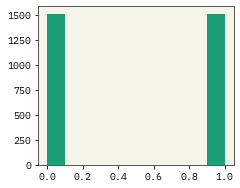

In [36]:
plt.hist(y_train)

In [28]:
y_train = np.concatenate([np.ones(X_train_positive.shape[0]), np.zeros(noisy_students.shape[0]),
                          np.zeros(noisy_students.shape[0]), np.ones(noisy_positive.shape[0])])

NameError: name 'noisy_students' is not defined

In [26]:
print(prob[np.argsort(prob[:,0])][-20:])

[[4.0269175]
 [4.0354743]
 [4.0436935]
 [4.0572243]
 [4.058332 ]
 [4.110489 ]
 [4.1153255]
 [4.1221724]
 [4.136988 ]
 [4.1575956]
 [4.1630955]
 [4.165518 ]
 [4.185598 ]
 [4.199795 ]
 [4.201902 ]
 [4.2046437]
 [4.2421584]
 [4.374268 ]
 [4.408584 ]
 [4.481833 ]]


(array([1394., 6918., 4564., 2862., 2138., 1723., 1377., 1033.,  670.,
         146.]),
 array([-4.7098265 , -3.7906606 , -2.8714945 , -1.9523287 , -1.0331627 ,
        -0.11399674,  0.8051692 ,  1.7243352 ,  2.643501  ,  3.5626671 ,
         4.481833  ], dtype=float32),
 <BarContainer object of 10 artists>)

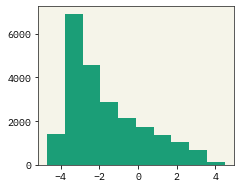

In [22]:
plt.hist(prob)

In [18]:
prob[np.argsort(prob[:,0])]

array([[-5.5013037],
       [-5.480882 ],
       [-5.4752   ],
       ...,
       [ 0.8435565],
       [ 1.0218409],
       [ 1.26882  ]], dtype=float32)

In [19]:
prob = model.predict([X_test_unlabeled, np.array([counts_aa(xi) for xi in X_test_unlabeled])])

In [ ]:
def decoder(seq_vector):
  alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
  seq = []
  for i, index in enumerate(seq_vector):
    if index == 0:
      break
    seq.append(alphabet[int(index)-1])
  seq = ''.join(seq)
  return seq
# need to decode postive and negative data to get UniRep representations
pos_sequences = []
for f in pos_data:
  pos_sequences.append(decoder(f))

neg_sequences = []
for f in neg_data:
  neg_sequences.append(decoder(f))

sampled_sequences = []
for i, f in enumerate(sampled_vecs):
    sampled_sequences.append(decoder(f))

In [ ]:
sampled_vecs[30]

array([11, 11, 15, 12, 11, 11,  8, 11, 15, 12, 14, 11,  5, 11, 20, 11, 12,
       12, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0])

In [ ]:
min(np.count_nonzero(sampled_vecs, axis=1))

2

In [ ]:
!pip install jax_unirep
# Generating UniRep representations for postives, negatives and unlableled (This cell takes long to run)
from jax_unirep import get_reps
h_avg, h_final, c_final = get_reps(pos_sequences)
pos_UniRep = h_avg

h_avg, h_final, c_final = get_reps(neg_sequences)
neg_UniRep = h_avg

h_avg, h_final, c_final = get_reps(sampled_sequences)
unlabeled_UniRep = h_avg

/usr/local/lib/python3.7/dist-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)


In [ ]:
# import sklearn.manifold
# import sklearn.decomposition
# cmap = plt.get_cmap('viridis')
# data = np.concatenate([pos_UniRep, neg_UniRep])
# weights = ['C1'] * pos_UniRep.shape[0] + ['C2'] * neg_UniRep.shape[0]
# embedded = sklearn.manifold.TSNE(n_components=2).fit_transform(data)
# plt.figure(figsize=(6,4), dpi=300)
# ax = plt.gca()
# s = 3
# ax.scatter(embedded[:pos_UniRep.shape[0], 0], embedded[:pos_UniRep.shape[0],1],
#                 c=weights[:pos_UniRep.shape[0]], s=s, edgecolors='face',
#                 linewidth=0.0, cmap=cmap, alpha=0.5, label='Positive')
# ax.scatter(embedded[pos_UniRep.shape[0]:, 0], embedded[pos_UniRep.shape[0]:,1],
#                 c=weights[pos_UniRep.shape[0]:], s=s, edgecolors='face',
#                 linewidth=0.0, cmap=cmap, alpha=0.5, label='Negative')
# plt.legend(loc='upper right', bbox_to_anchor=(1.3, 0.9))
# plt.savefig(f'TSNE_hemolytic.png', dpi=600, transparent=False, bbox_inches='tight')

In [ ]:
# import umap
# reducer = umap.UMAP()
# embedded = reducer.fit_transform(data)
# plt.figure(figsize=(6,4), dpi=300)
# ax = plt.gca()
# ax.scatter(embedded[:pos_UniRep.shape[0], 0], embedded[:pos_UniRep.shape[0],1],
#                 c=weights[:pos_UniRep.shape[0]], s=s, edgecolors='face',
#                 linewidth=0.0, cmap=cmap, alpha=0.5, label='Positive')
# ax.scatter(embedded[pos_UniRep.shape[0]:, 0], embedded[pos_UniRep.shape[0]:,1],
#                 c=weights[pos_UniRep.shape[0]:], s=s, edgecolors='face',
#                 linewidth=0.0, cmap=cmap, alpha=0.5, label='Negative')
# plt.legend(loc='upper right', bbox_to_anchor=(1.3, 0.9))
# plt.savefig(f'UMAP_hemolytic.png', dpi=600, transparent=False, bbox_inches='tight')

In [ ]:
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.model_selection import KFold
# from sklearn.metrics import f1_score
# from sklearn.metrics import recall_score
# kf = KFold(n_splits=5, random_state=None, shuffle=True)
# f1_scores = []
# recall_scores = []
# i = 0

# for train_index, test_index in kf.split(pos_UniRep):
#     X_train_positive_lof, X_test_positive_lof = pos_UniRep[train_index], pos_UniRep[test_index]
# #     s_train_positive_svm = np.ones(X_train_positive_svm.shape[0])
# #     s_test_positive_svm = y[train_index], y[test_index]
#     s_test_lof = np.ones(X_test_positive_lof.shape[0])
#     lof = LocalOutlierFactor(n_neighbors=64, algorithm='auto',
#                              metric='cosine', contamination=0.01,
#                              novelty=True, n_jobs=20, leaf_size=40)
#     lof.fit(X_train_positive_lof)
# #     X_validation_svm = np.concatenate([X_positive_test, X_unlabeled_test])

#     # Make prediction
#     s_pred = lof.predict(X_test_positive_lof)
#     f1 = f1_score(s_test_lof, s_pred, average='macro')
#     r = recall_score(s_test_lof, s_pred, average='macro')
#     print(f'Fold {i+1} - recall : {r:.3f}, f1 score : {f1:.3f}')
#     f1_scores.append(f1)
#     recall_scores.append(r)
#     i += 1
# #     break
# # lof_f1_score
# lof_f1_score = np.mean(f1_scores)
# lof_recall_score = np.mean(recall_scores)
# print(f'\nMean 5-Fold\n f1 score = {lof_f1_score:.3f}\n recall = {lof_recall_score:.3f}')

In [ ]:
def mahalanobis_distance(x, data):
    data = np.unique(data, axis=0)
    x_minus_mu = x - np.mean(data, axis=0, keepdims=True)
    cov = np.cov(data.T)
    inv_covmat = np.linalg.pinv(cov)
    left_term = x_minus_mu @ inv_covmat
    mahal = left_term @ x_minus_mu.T
    return mahal.diagonal()
unlabeled_mahal_d = mahalanobis_distance(unlabeled_UniRep, pos_UniRep)
sorted_max_mahal_d_index = np.argsort(unlabeled_mahal_d)[::-1]
outlier_index = sorted_max_mahal_d_index[sorted_max_mahal_d_index[:400]]
initial_RNs = X_unlabeled[outlier_index]

In [ ]:
pos_data.shape

(1826, 190)

In [ ]:
# Shuffling data
shuffled_indices = np.random.permutation(len(pos_data))
X_positive = pos_data[shuffled_indices]
shuffled_indices = np.random.permutation(len(neg_data))
X_negative = neg_data[shuffled_indices]
# shuffled_indices = np.random.permutation(len(sampled_vecs))
# X_unlabeled = sampled_vecs[shuffled_indices]

In [ ]:
@dataclass
class Config:
    vocab_size: int
    example_number: int
    batch_size: int
    buffer_size: int
    rnn_units: int
    hidden_dim: int
    embedding_dim: int
    reg_strength: float
    lr: float
    drop_rate: float
        
config = Config(vocab_size=21, # include gap
                example_number=len(X_positive), 
                batch_size=16, 
                buffer_size=10000,
                rnn_units=64,
                hidden_dim=64,
                embedding_dim=32,
                reg_strength=0,
                lr=1e-3,
                drop_rate=0.1
               )

def counts_aa(vec):
    counts =  tf.histogram_fixed_width(vec, [0, 20], nbins=21)[1:]
    return counts/tf.reduce_sum(counts)

def build_model(L):
    inputs = tf.keras.Input(shape=(L,))
    input_f = tf.keras.Input(shape=(20,))
    # make embedding and indicate that 0 should be treated as padding mask
    e = tf.keras.layers.Embedding(input_dim=config.vocab_size, 
                                        output_dim=config.embedding_dim,
                                        mask_zero=True)(inputs)

    # RNN layer
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units, return_sequences=True))(e)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(config.rnn_units))(x)
    x = tf.keras.layers.Concatenate()([x, input_f])
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # a dense hidden layer
    x = tf.keras.layers.Dense(
        config.hidden_dim, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    x = tf.keras.layers.Dense(
        config.hidden_dim // 4, 
        activation='relu', 
        kernel_regularizer=tf.keras.regularizers.l2(config.reg_strength))(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dropout(config.drop_rate)(x)
    # predicting prob, so no activation
    yhat = tf.keras.layers.Dense(1)(x)

    model = tf.keras.Model(inputs=[inputs, input_f], outputs=yhat, name='hemo-rnn')
    return model

In [ ]:
from sklearn.model_selection import train_test_split
X_train_positive, X_test_positive, y_train_positive, y_test_positive = train_test_split(X_positive, np.ones(X_positive.shape[0]),
                                                                                        test_size=0.2, random_state=42)

In [ ]:
RNs = initial_RNs
down_sampled_X_train = X_train_positive[np.random.choice(X_train_positive.shape[0], size=RNs.shape[0], replace=False)]
X_train_with_RN = np.concatenate([X_train_positive, RNs])
counts_X_train_with_RN= np.array([counts_aa(xi) for xi in X_train_with_RN])
y_train_with_RN = np.concatenate([np.ones(X_train_positive.shape[0]), np.zeros(RNs.shape[0])])
shuffler = np.random.permutation(len(X_train_with_RN))
X_train_with_RN = X_train_with_RN[shuffler]
# counts_X_train_with_RN = counts_X_train_with_RN[shuffler]
y_train_with_RN = y_train_with_RN[shuffler]
X_test = np.concatenate([X_test_positive, X_negative])
y_test = np.concatenate([np.ones(y_test_positive.shape[0]), np.zeros(X_negative.shape[0])])
# removing intial RN seeds from unlabeled
RU = np.delete(X_unlabeled, outlier_index[0],axis=0)
# RU = X_unlabeled
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.9,
                                                        patience=5, min_lr=1e-7)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, min_delta=1e-2, restore_best_weights=True)
L = None
decay_epochs = 50
N = len(X_train_with_RN)
decay_steps = N  // config.batch_size * decay_epochs
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
  config.lr, decay_steps, alpha=1e-3)
for i in tqdm(range(50)):
    tf.keras.backend.clear_session()
    model = build_model(L)
    model.compile(
            optimizer=tf.optimizers.Adam(1e-3),
            loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)],
            )
    history = model.fit(
        [X_train_with_RN, np.array([counts_aa(xi) for xi in X_train_with_RN])] , y_train_with_RN,
        validation_data=([X_test, np.array([counts_aa(xi) for xi in X_test])] , y_test), 
        epochs=50,
        batch_size=16,
    #     batch_size=64,
    #     steps_per_epoch=100,
        # early_stopping
        callbacks=[reduce_lr, early_stopping],
        verbose=1,
    #         class_weight=class_weights
    )
    prob = model.predict([RU, np.array([counts_aa(xi) for xi in RU])])
    V = RU[np.argsort(prob[:,0])] 
#     break
#     print(f'Negatives found: {V.shape[0]}')
#     if V.shape[0] == 0:
#         print('All unlabeled were predicted as positive')
#         RNs = outlier_values
#         break
    # print(V.shape)
#     else:
        # print(RNs.shape)
#         n_downsample = V.shape[0] - X_train_positive_svm.shape[0]
#         print(RNs.shape) 
#     if i == 0:
#         RNs = np.empty(shape=(0, 200))

    RNs = np.concatenate([RNs, V[:40*(i+1)]])
#     RNs = V[:120*(i+1)]
#         RU = RU[:][np.squeeze(prob > 0.001)]
    RU = np.delete(RU, np.argsort(prob[:,0])[:40*(i+1)], axis=0)
    print(f'Reliable negative size: {RNs.shape[0]}   Unlabeled size: {RU.shape[0]}')
    if RU.shape[0] == 0:
        print('All unlabeled were predicted as negative')
        break
    if RNs.shape[0] > X_train_positive.shape[0]:
        print('RNs size exceeded positives size')
        break
#         RNs = equalizer(X_train_positive_lof, RNs)
    down_sampled_X_train = X_train_positive[np.random.choice(X_train_positive.shape[0], size=RNs.shape[0], replace=False)]
    print(f'pos size: {down_sampled_X_train.shape[0]} RN size: {RNs.shape[0]}')
    X_train_with_RN = np.concatenate([X_train_positive, RNs])
    counts_X_train_with_RN = np.array([counts_aa(xi) for xi in X_train_with_RN])
    y_train_with_RN = np.concatenate([np.ones(X_train_positive.shape[0]), np.zeros(RNs.shape[0])])
    shuffler = np.random.permutation(len(X_train_with_RN))
    X_train_with_RN = X_train_with_RN[shuffler]
    counts_X_train_with_RN = counts_X_train_with_RN[shuffler]
    y_train_with_RN = y_train_with_RN[shuffler]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50
117/117 [==============================] - 22s 76ms/step - loss: 0.5707 - auc: 0.5098 - binary_accuracy: 0.7608 - val_loss: 1.6095 - val_auc: 0.5522 - val_binary_accuracy: 0.0468 - lr: 0.0010
Epoch 2/50
117/117 [==============================] - 6s 49ms/step - loss: 0.5213 - auc: 0.5985 - binary_accuracy: 0.7769 - val_loss: 1.5782 - val_auc: 0.6067 - val_binary_accuracy: 0.0480 - lr: 0.0010
Epoch 3/50
117/117 [==============================] - 5s 44ms/step - loss: 0.4772 - auc: 0.7050 - binary_accuracy: 0.7866 - val_loss: 2.1362 - val_auc: 0.5782 - val_binary_accuracy: 0.0526 - lr: 0.0010
Epoch 4/50
117/117 [==============================] - 5s 45ms/step - loss: 0.4531 - auc: 0.7461 - binary_accuracy: 0.8016 - val_loss: 1.4990 - val_auc: 0.6295 - val_binary_accuracy: 0.1776 - lr: 0.0010
Epoch 5/50
117/117 [==============================] - 5s 44ms/step - loss: 0.4156 - auc: 0.7991 - binary_accuracy: 0.8172 - val_loss: 1.9712 - val_auc: 0.5994 - val_binary_accuracy: 0.1816 - 

  2%|▏         | 1/50 [05:07<4:10:45, 307.06s/it]

Epoch 1/50
119/119 [==============================] - 24s 86ms/step - loss: 0.5561 - auc: 0.5412 - binary_accuracy: 0.7632 - val_loss: 1.4593 - val_auc: 0.5774 - val_binary_accuracy: 0.0468 - lr: 0.0010
Epoch 2/50
119/119 [==============================] - 5s 46ms/step - loss: 0.5141 - auc: 0.6636 - binary_accuracy: 0.7732 - val_loss: 1.4410 - val_auc: 0.5625 - val_binary_accuracy: 0.0500 - lr: 0.0010
Epoch 3/50
119/119 [==============================] - 5s 45ms/step - loss: 0.4924 - auc: 0.6986 - binary_accuracy: 0.7832 - val_loss: 1.6318 - val_auc: 0.6084 - val_binary_accuracy: 0.1139 - lr: 0.0010
Epoch 4/50
119/119 [==============================] - 5s 45ms/step - loss: 0.4533 - auc: 0.7667 - binary_accuracy: 0.8000 - val_loss: 1.6169 - val_auc: 0.6200 - val_binary_accuracy: 0.1045 - lr: 0.0010
Epoch 5/50
119/119 [==============================] - 5s 44ms/step - loss: 0.4354 - auc: 0.7879 - binary_accuracy: 0.8079 - val_loss: 1.9331 - val_auc: 0.6145 - val_binary_accuracy: 0.1175 - 

  4%|▍         | 2/50 [08:21<3:12:42, 240.88s/it]

Epoch 1/50
124/124 [==============================] - 25s 74ms/step - loss: 0.6183 - auc: 0.5296 - binary_accuracy: 0.7066 - val_loss: 1.3968 - val_auc: 0.5976 - val_binary_accuracy: 0.0466 - lr: 0.0010
Epoch 2/50
124/124 [==============================] - 5s 43ms/step - loss: 0.5252 - auc: 0.7021 - binary_accuracy: 0.7530 - val_loss: 1.9021 - val_auc: 0.5898 - val_binary_accuracy: 0.0802 - lr: 0.0010
Epoch 3/50
124/124 [==============================] - 5s 43ms/step - loss: 0.4591 - auc: 0.7821 - binary_accuracy: 0.8020 - val_loss: 1.5719 - val_auc: 0.6080 - val_binary_accuracy: 0.1717 - lr: 0.0010
Epoch 4/50
124/124 [==============================] - 5s 44ms/step - loss: 0.4392 - auc: 0.8034 - binary_accuracy: 0.8131 - val_loss: 1.7136 - val_auc: 0.6248 - val_binary_accuracy: 0.1697 - lr: 0.0010
Epoch 5/50
124/124 [==============================] - 5s 44ms/step - loss: 0.4081 - auc: 0.8352 - binary_accuracy: 0.8278 - val_loss: 1.9360 - val_auc: 0.6489 - val_binary_accuracy: 0.1837 - 

  6%|▌         | 3/50 [11:56<2:59:27, 229.10s/it]

Epoch 1/50
132/132 [==============================] - 26s 72ms/step - loss: 0.6277 - auc: 0.5780 - binary_accuracy: 0.6800 - val_loss: 1.1841 - val_auc: 0.5476 - val_binary_accuracy: 0.2427 - lr: 0.0010
Epoch 2/50
132/132 [==============================] - 6s 43ms/step - loss: 0.4620 - auc: 0.8035 - binary_accuracy: 0.8038 - val_loss: 1.9121 - val_auc: 0.5865 - val_binary_accuracy: 0.1345 - lr: 0.0010
Epoch 3/50
132/132 [==============================] - 6s 44ms/step - loss: 0.4245 - auc: 0.8298 - binary_accuracy: 0.8224 - val_loss: 1.7319 - val_auc: 0.5940 - val_binary_accuracy: 0.1253 - lr: 0.0010
Epoch 4/50
132/132 [==============================] - 6s 43ms/step - loss: 0.3974 - auc: 0.8538 - binary_accuracy: 0.8376 - val_loss: 1.6460 - val_auc: 0.6207 - val_binary_accuracy: 0.1409 - lr: 0.0010
Epoch 5/50
132/132 [==============================] - 6s 42ms/step - loss: 0.3819 - auc: 0.8636 - binary_accuracy: 0.8438 - val_loss: 1.4342 - val_auc: 0.6312 - val_binary_accuracy: 0.1969 - 

  8%|▊         | 4/50 [16:25<3:07:41, 244.81s/it]

Epoch 1/50
142/142 [==============================] - 25s 66ms/step - loss: 0.5668 - auc: 0.7302 - binary_accuracy: 0.7239 - val_loss: 1.4940 - val_auc: 0.6000 - val_binary_accuracy: 0.1842 - lr: 0.0010
Epoch 2/50
142/142 [==============================] - 6s 40ms/step - loss: 0.4311 - auc: 0.8352 - binary_accuracy: 0.8212 - val_loss: 1.6847 - val_auc: 0.6000 - val_binary_accuracy: 0.1344 - lr: 0.0010
Epoch 3/50
142/142 [==============================] - 6s 40ms/step - loss: 0.3861 - auc: 0.8685 - binary_accuracy: 0.8482 - val_loss: 1.5777 - val_auc: 0.6131 - val_binary_accuracy: 0.1321 - lr: 0.0010
Epoch 4/50
142/142 [==============================] - 6s 41ms/step - loss: 0.3677 - auc: 0.8827 - binary_accuracy: 0.8469 - val_loss: 1.7588 - val_auc: 0.6222 - val_binary_accuracy: 0.1732 - lr: 0.0010
Epoch 5/50
142/142 [==============================] - 6s 41ms/step - loss: 0.3510 - auc: 0.8969 - binary_accuracy: 0.8504 - val_loss: 1.4994 - val_auc: 0.6154 - val_binary_accuracy: 0.1950 - 

 10%|█         | 5/50 [20:50<3:08:56, 251.91s/it]

Epoch 1/50
154/154 [==============================] - 23s 63ms/step - loss: 0.5223 - auc: 0.7987 - binary_accuracy: 0.7512 - val_loss: 1.5514 - val_auc: 0.5765 - val_binary_accuracy: 0.1343 - lr: 0.0010
Epoch 2/50
154/154 [==============================] - 6s 39ms/step - loss: 0.3964 - auc: 0.8724 - binary_accuracy: 0.8431 - val_loss: 1.5930 - val_auc: 0.6364 - val_binary_accuracy: 0.1380 - lr: 0.0010
Epoch 3/50
154/154 [==============================] - 6s 39ms/step - loss: 0.3565 - auc: 0.8998 - binary_accuracy: 0.8553 - val_loss: 1.8644 - val_auc: 0.6053 - val_binary_accuracy: 0.1624 - lr: 0.0010
Epoch 4/50
154/154 [==============================] - 6s 39ms/step - loss: 0.3415 - auc: 0.9058 - binary_accuracy: 0.8622 - val_loss: 1.6669 - val_auc: 0.6337 - val_binary_accuracy: 0.1599 - lr: 0.0010
Epoch 5/50
154/154 [==============================] - 6s 39ms/step - loss: 0.3248 - auc: 0.9131 - binary_accuracy: 0.8776 - val_loss: 1.5886 - val_auc: 0.6288 - val_binary_accuracy: 0.1911 - 

 12%|█▏        | 6/50 [24:59<3:04:07, 251.08s/it]

Epoch 1/50
169/169 [==============================] - 25s 66ms/step - loss: 0.5020 - auc: 0.8234 - binary_accuracy: 0.7548 - val_loss: 1.6782 - val_auc: 0.5638 - val_binary_accuracy: 0.1057 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - 6s 37ms/step - loss: 0.3598 - auc: 0.8971 - binary_accuracy: 0.8563 - val_loss: 1.4521 - val_auc: 0.6007 - val_binary_accuracy: 0.1311 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - 6s 37ms/step - loss: 0.3358 - auc: 0.9075 - binary_accuracy: 0.8685 - val_loss: 1.6653 - val_auc: 0.5777 - val_binary_accuracy: 0.1202 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - 6s 37ms/step - loss: 0.3133 - auc: 0.9217 - binary_accuracy: 0.8789 - val_loss: 1.4283 - val_auc: 0.6005 - val_binary_accuracy: 0.2154 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - 6s 37ms/step - loss: 0.2988 - auc: 0.9280 - binary_accuracy: 0.8819 - val_loss: 1.6427 - val_auc: 0.6112 - val_binary_accuracy: 0.1664 - 

 12%|█▏        | 6/50 [29:41<3:37:46, 296.97s/it]

Reliable negative size: 1520   Unlabeled size: 44529
RNs size exceeded positives size


Now train with found RNs and positives. We do testing and validation based on the known negative data and a small subset of unobserved postives

In [ ]:
from sklearn.model_selection import train_test_split
X_train_positive, X_test_positive, y_train_positive, y_test_positive = train_test_split(pos_data,
                                                                                        np.ones(pos_data.shape[0]),
                                                                                        test_size=0.1, random_state=25)
X_val_positive, X_test_positive, y_val_positive, y_test_positive = train_test_split(X_test_positive,
                                                                                        y_test_positive,
                                                                                        test_size=0.1, random_state=25)
labels = np.concatenate(
    (
        np.ones((X_train_positive.shape[0], 1), dtype=pos_data.dtype),
        np.zeros((RNs.shape[0], 1), dtype=X_unlabeled.dtype),
    ),
    axis=0,
)

features = np.concatenate((X_train_positive, RNs), axis=0)

# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=25)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=25)
split = X_negative.shape[0]//5 *4
X_val_negative, X_test_negative = X_negative[:split], X_negative[split:]
X_val = np.append(X_val_positive, X_val_negative, axis=0)
y_val = np.append(y_val_positive, np.zeros(X_val_negative.shape[0]))
X_test = np.append(X_test_positive, X_test_negative, axis=0)
y_test = np.append(y_test_positive, np.zeros(X_test_negative.shape[0]))
shuffled_indices = np.random.permutation(len(labels))
labels = labels[shuffled_indices]
features = features[shuffled_indices]

In [ ]:
tf.keras.backend.clear_session()
model = build_model(L)
#   L = 190
#   model = build_CNN_model(L, reg=0, add_dropout=True)
decay_epochs = 50
N = len(features)
decay_steps = N  // config.batch_size * decay_epochs
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(
  config.lr, decay_steps, alpha=1e-3)
opt = tf.optimizers.Adam(lr_decayed_fn)
model.compile(
  opt,
  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  steps_per_execution = 60 if use_tpu else None,
  metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=2)])

In [ ]:
result = model.fit(
    [features, np.array([counts_aa(xi) for xi in features])], labels, 
    validation_data=([X_val, np.array([counts_aa(xi) for xi in X_val])] , y_val),
    callbacks=[tf.keras.callbacks.LambdaCallback(
        on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
        ),
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=10)],
    epochs=150, batch_size=16)

lr = 0.001
Epoch 1/150
198/198 [==============================] - 27s 57ms/step - loss: 0.4653 - auc: 0.8576 - binary_accuracy: 0.5827 - val_loss: 1.4843 - val_auc: 0.5885 - val_binary_accuracy: 0.8830
lr = 0.0009990043
Epoch 2/150
198/198 [==============================] - 6s 32ms/step - loss: 0.3350 - auc: 0.9116 - binary_accuracy: 0.6684 - val_loss: 1.7876 - val_auc: 0.6240 - val_binary_accuracy: 0.5268
lr = 0.0009960213
Epoch 3/150
198/198 [==============================] - 6s 32ms/step - loss: 0.3037 - auc: 0.9263 - binary_accuracy: 0.7230 - val_loss: 1.5799 - val_auc: 0.6391 - val_binary_accuracy: 0.6959
lr = 0.0009910627
Epoch 4/150
198/198 [==============================] - 6s 32ms/step - loss: 0.2795 - auc: 0.9385 - binary_accuracy: 0.7468 - val_loss: 1.7714 - val_auc: 0.6171 - val_binary_accuracy: 0.5971
lr = 0.0009841485
Epoch 5/150
198/198 [==============================] - 6s 32ms/step - loss: 0.2760 - auc: 0.9401 - binary_accuracy: 0.7619 - val_loss: 1.8527 - val_auc: 0.6

48/48 [==============================] - 0s 8ms/step - loss: 2.8141 - auc: 0.6445 - binary_accuracy: 0.3349


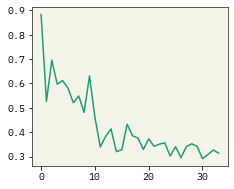

In [ ]:
plt.plot(result.history['val_binary_accuracy'])
test_result = model.evaluate([X_test, np.array([counts_aa(xi) for xi in X_test])], y_test)
plt.show()

Text(0.5, 0.98, 'Positive test data score')

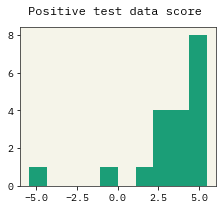

In [ ]:
plt.hist(model.predict([X_test_positive, np.array([counts_aa(xi) for xi in X_test_positive])]))
plt.suptitle('Positive test data score')

Text(0.5, 0.98, 'Negative test data score')

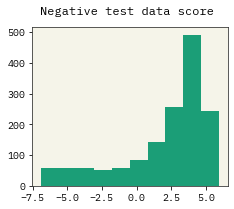

In [ ]:
plt.hist(model.predict([X_test_negative, np.array([counts_aa(xi) for xi in X_test_negative])]))
plt.suptitle('Negative test data score')

In [ ]:
y_hat_test = model.predict([X_test, np.array([counts_aa(xi) for xi in X_test])])

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
fpr, tpr, thresholds = roc_curve(y_test, y_hat_test, drop_intermediate=False)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
best_accuracy_threshold = thresholds[ix]
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
adjusted_y_hat_test = [1 if m>best_accuracy_threshold else 0 for m in y_hat_test]
acc = accuracy_score(y_test, adjusted_y_hat_test, normalize=True)
print(f'Adjusted Accuracy with new threshold: {acc:.3f}')

Best Threshold=3.988921, G-Mean=0.652
Adjusted Accuracy with new threshold: 0.672


Let's see how the model works with classical positive-negative classification

In [ ]:
labels = np.concatenate(
    (
        np.ones(pos_data.shape[0], dtype=pos_data.dtype),
        np.zeros(neg_data.shape[0], dtype=neg_data.dtype),
    ),
    axis=0,
)
features = np.concatenate((pos_data, neg_data), axis=0)
counts_features = np.array([counts_aa(xi) for xi in features])
shuffler = np.random.permutation(len(features))
features = features[shuffler]
counts_features = counts_features[shuffler]
labels = labels[shuffler]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=25)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2, random_state=25)

In [ ]:
tf.keras.backend.clear_session()
model = build_model(L)
opt = tf.optimizers.Adam(lr_decayed_fn)
model.compile(
      opt,
      loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
      steps_per_execution = 60 if use_tpu else None,
      metrics=[tf.keras.metrics.AUC(from_logits=True), tf.keras.metrics.BinaryAccuracy(threshold=0)])

In [ ]:
result = model.fit(
    [X_train, np.array([counts_aa(xi) for xi in X_train])], y_train, 
    validation_data=([X_val, np.array([counts_aa(xi) for xi in X_val])] , y_val),
    callbacks=[tf.keras.callbacks.LambdaCallback(
        on_epoch_begin=lambda epochs,logs: print('lr =',lr_decayed_fn(opt.iterations).numpy())
        ),
        tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', restore_best_weights=True, patience=5)],
    epochs=150)

Epoch 1/150
lr = 0.001
262/262 [==============================] - 96s 336ms/step - loss: 0.4857 - auc: 0.6220 - binary_accuracy: 0.8009 - val_loss: 0.4455 - val_auc: 0.7045 - val_binary_accuracy: 0.8121
Epoch 2/150
lr = 0.0009984514
262/262 [==============================] - 84s 320ms/step - loss: 0.4543 - auc: 0.7070 - binary_accuracy: 0.8003 - val_loss: 0.4416 - val_auc: 0.7056 - val_binary_accuracy: 0.8134
Epoch 3/150
lr = 0.0009938151
262/262 [==============================] - 84s 321ms/step - loss: 0.4457 - auc: 0.7245 - binary_accuracy: 0.7999 - val_loss: 0.4337 - val_auc: 0.7337 - val_binary_accuracy: 0.8081
Epoch 4/150
lr = 0.0009861198
262/262 [==============================] - 84s 322ms/step - loss: 0.4358 - auc: 0.7424 - binary_accuracy: 0.8074 - val_loss: 0.4559 - val_auc: 0.7002 - val_binary_accuracy: 0.8134
Epoch 5/150
lr = 0.00097541336
262/262 [==============================] - 84s 320ms/step - loss: 0.4275 - auc: 0.7573 - binary_accuracy: 0.8077 - val_loss: 0.4497 - va

6/6 [==============================] - 0s 70ms/step - loss: 0.4185 - auc: 0.8041 - binary_accuracy: 0.8342


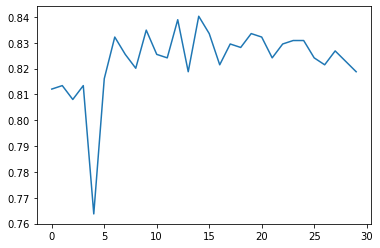

In [ ]:
plt.plot(result.history['val_binary_accuracy'])
test_result = model.evaluate([X_test, np.array([counts_aa(xi) for xi in X_test])], y_test)
plt.show()